In [1]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import os

## Load data

In [2]:
# load data
root = os.getcwd()
dataset_dir = os.path.join(root, 'Data-15')

In [3]:
raw_df = pd.DataFrame()

In [129]:
# Initialize an empty list to store data
data_list = []

list_of_folders = os.listdir(dataset_dir)

fs  = 1/100000 #Hz

first_iter = True
# Read matlab files
for folder in list_of_folders:
    path = os.path.join(dataset_dir, folder)
    list_of_files = os.listdir(path)
    label = str(folder)
    print(label)
    for file in list_of_files:
        if file.endswith('.mat'):
            # Read matlab file
            mat = scipy.io.loadmat(os.path.join(path, file))

            # Get data and append to the list
            ft =np.fft.fft(mat['tpd']['Data'][0][0][0])
            if first_iter:
                freqs = np.fft.fftfreq(len(mat['tpd']['Data'][0][0][0]), fs)
                fc_low = 57
                fc_high = 63
                w = np.zeros(len(freqs))
                w[np.where(fc_high<freqs)] = 1
                w[np.where(freqs<fc_low)] = 1
                first_iter = False
            
            ft_cut =  ft*w
            abs_ft_cut_norm = abs(ft_cut/np.linalg.norm(ft_cut))
            data_list.append({'label': label, 
                              'time_sig': mat['tpd']['Data'][0][0][0], 
                              'fft' : ft, 
                              'fft_filtered' : ft_cut,
                                'AFFTN' : abs_ft_cut_norm})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display DataFrame description
df.head(20)

Fun
HairDryer
Heater
LightBulb
Refrigirator


,label,time_sig,fft,fft_filtered,AFFTN
0,Fun,"[-2.4666667, -2.4627452, -2.492157, -2.484314,...","[(198.70590213674586+0j), (-2.232318014673014+...","[(198.70590213674586+0j), (-2.232318014673014+...","[0.005377148973216997, 6.636378875811134e-05, ..."
1,Fun,"[-2.5058825, -2.5186276, -2.516667, -2.509804,...","[(207.29315045813564+0j), (0.06328588688745879...","[(207.29315045813564+0j), (0.06328588688745879...","[0.005607460868703376, 2.4829071510349633e-05,..."
2,Fun,"[-2.4617648, -2.4627452, -2.4862747, -2.480392...","[(205.7147244606167+0j), (0.4037775054453768-1...","[(205.7147244606167+0j), (0.4037775054453768-1...","[0.005564825469602966, 3.7234935272612405e-05,..."
3,Fun,"[-2.4715688, -2.4833336, -2.4990199, -2.512745...","[(203.39020591438748+0j), (-1.8787844941233909...","[(203.39020591438748+0j), (-1.8787844941233909...","[0.00550189034990228, 5.5823539349775295e-05, ..."
4,Fun,"[-2.5000002, -2.527451, -2.5147061, -2.5068629...","[(206.01667345920578+0j), (0.9877989466016359+...","[(206.01667345920578+0j), (0.9877989466016359+...","[0.005574801233468206, 3.223743934000774e-05, ..."
5,Fun,"[-2.442157, -2.4558825, -2.4509804, -2.4441178...","[(207.2235381102655+0j), (-2.9499456177426944+...","[(207.2235381102655+0j), (-2.9499456177426944+...","[0.005605440248091155, 8.646357402670608e-05, ..."
6,Fun,"[-2.4715688, -2.4509804, -2.4715688, -2.481372...","[(210.84413074038457+0j), (1.9641885663242178+...","[(210.84413074038457+0j), (1.9641885663242178+...","[0.005703107949559287, 6.293939560171723e-05, ..."
7,Fun,"[-2.4127452, -2.4284315, -2.4362748, -2.439216...","[(208.12254292110447+0j), (0.6534965270141633+...","[(208.12254292110447+0j), (0.6534965270141633+...","[0.005629775592066573, 2.334292978867479e-05, ..."
8,Fun,"[-2.4970589, -2.501961, -2.5029414, -2.5147061...","[(204.7019788409816+0j), (0.19208824095965787-...","[(204.7019788409816+0j), (0.19208824095965787-...","[0.005537365539226825, 2.4106998552201408e-05,..."
9,Fun,"[-2.4666667, -2.4901962, -2.5039217, -2.493137...","[(208.51472379313782+0j), (0.852987544582974+0...","[(208.51472379313782+0j), (0.852987544582974+0...","[0.005640692140742458, 2.4327094866918516e-05,..."


## Filter 60Hz


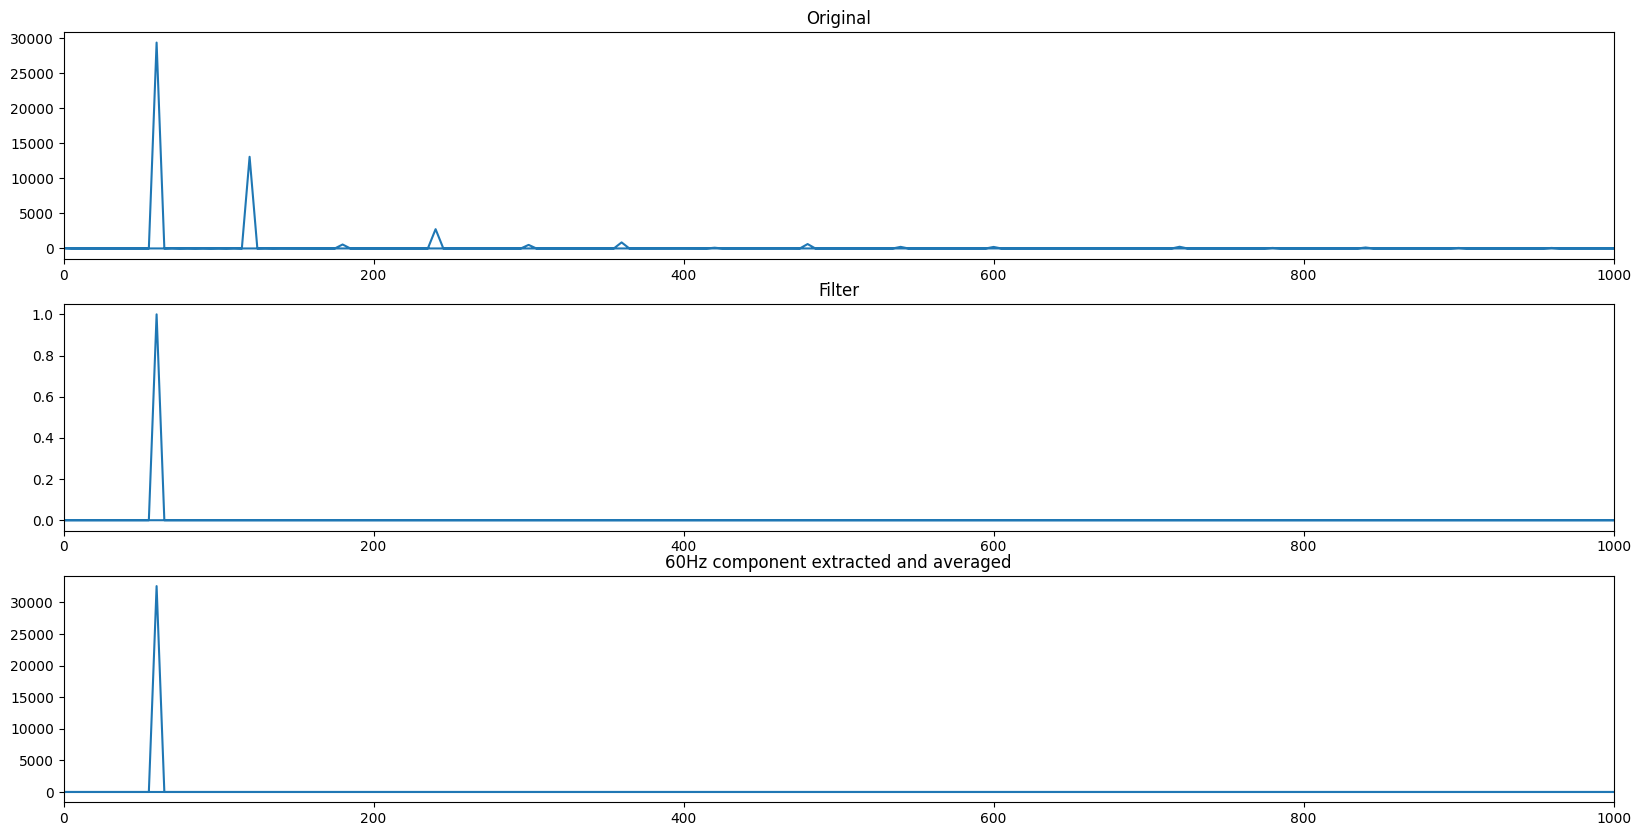

In [95]:
# cut 60Hz
w= np.zeros(len(df['fft'][0]))
fs  = 1/100000 #Hz
freqs = np.fft.fftfreq(len(df['fft'][0]), fs)
fc_low = 59
fc_high = 61
w[np.where(fc_high<freqs)] = 1
w[np.where(freqs<fc_low)] = 1
w_sin = 1-w
avg_sin = abs(df['fft'].apply(lambda x: x*w_sin)).mean()

plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(freqs, avg_sin)
plt.title('60Hz component extracted and averaged')
plt.xlim(0, 1000)
plt.subplot(3,1,1)
plt.plot(freqs, abs(df['fft'][33]))
plt.title('Original')
plt.xlim(0, 1000)
plt.subplot(3,1,2)
plt.plot(freqs, w_sin)
plt.xlim(0, 1000)
plt.title('Filter')
plt.show()


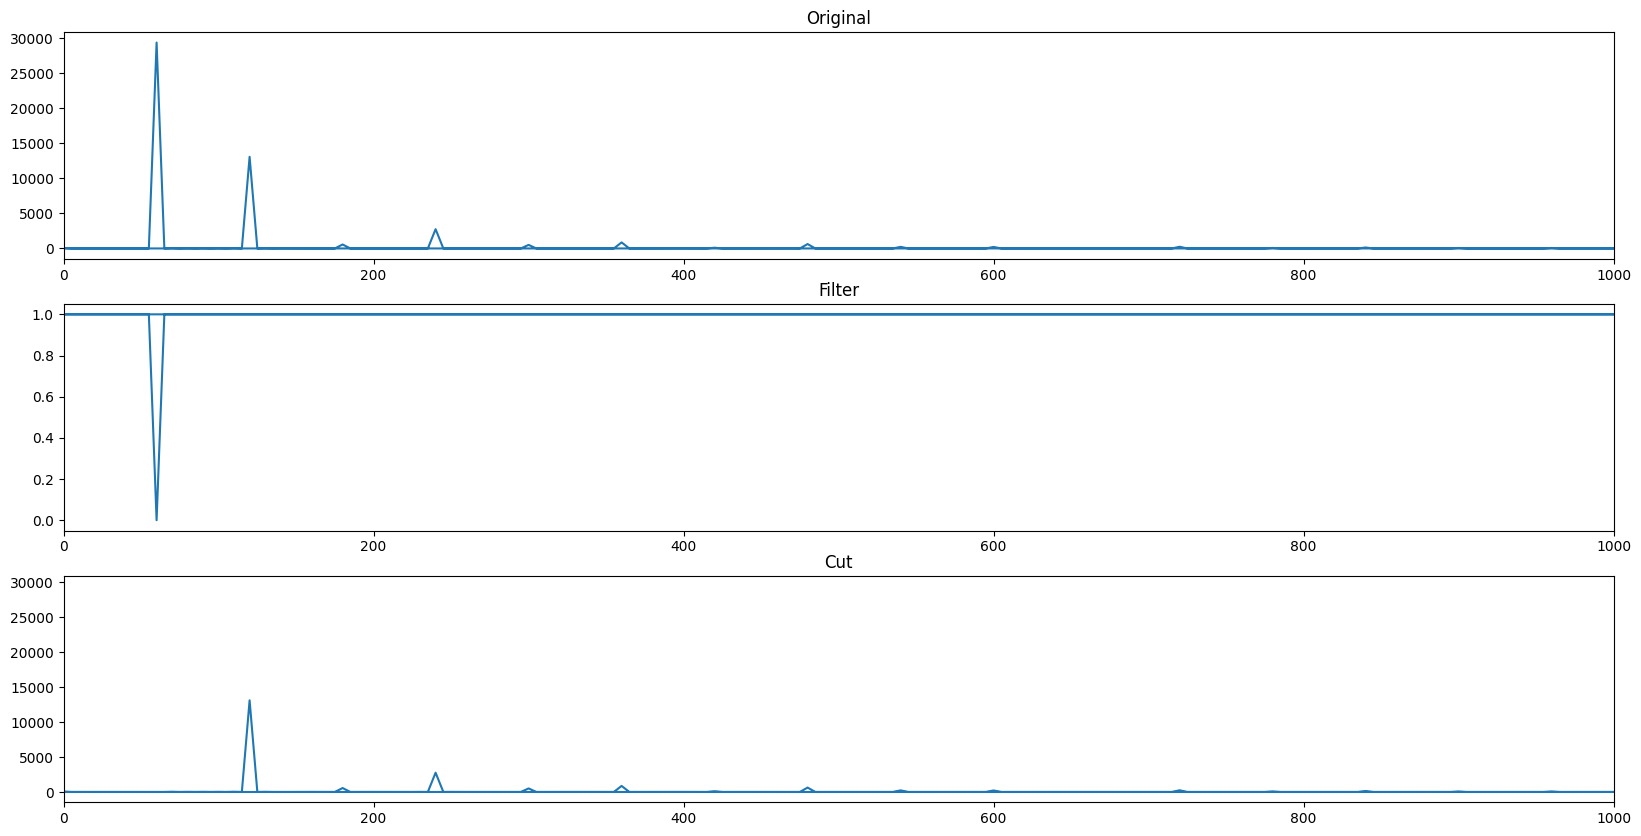

In [79]:
# cut 60Hz
w= np.zeros(len(df['fft'][0]))
fs  = 1/100000 #Hz
freqs = np.fft.fftfreq(len(df['fft'][0]), fs)
fc_low = 59
fc_high = 61
w[np.where(fc_high<freqs)] = 1
w[np.where(freqs<fc_low)] = 1
df['fft_cut'] = df['fft'].apply(lambda x: x*w)

plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(freqs, abs(df['fft_cut'][30]))
plt.title('Cut')
plt.xlim(0, 1000)
plt.subplot(3,1,1)
plt.plot(freqs, abs(df['fft'][33]))
plt.title('Original')
plt.xlim(0, 1000)
plt.subplot(3,1,2)
plt.plot(freqs, w)
plt.xlim(0, 1000)
plt.title('Filter')
plt.show()


C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


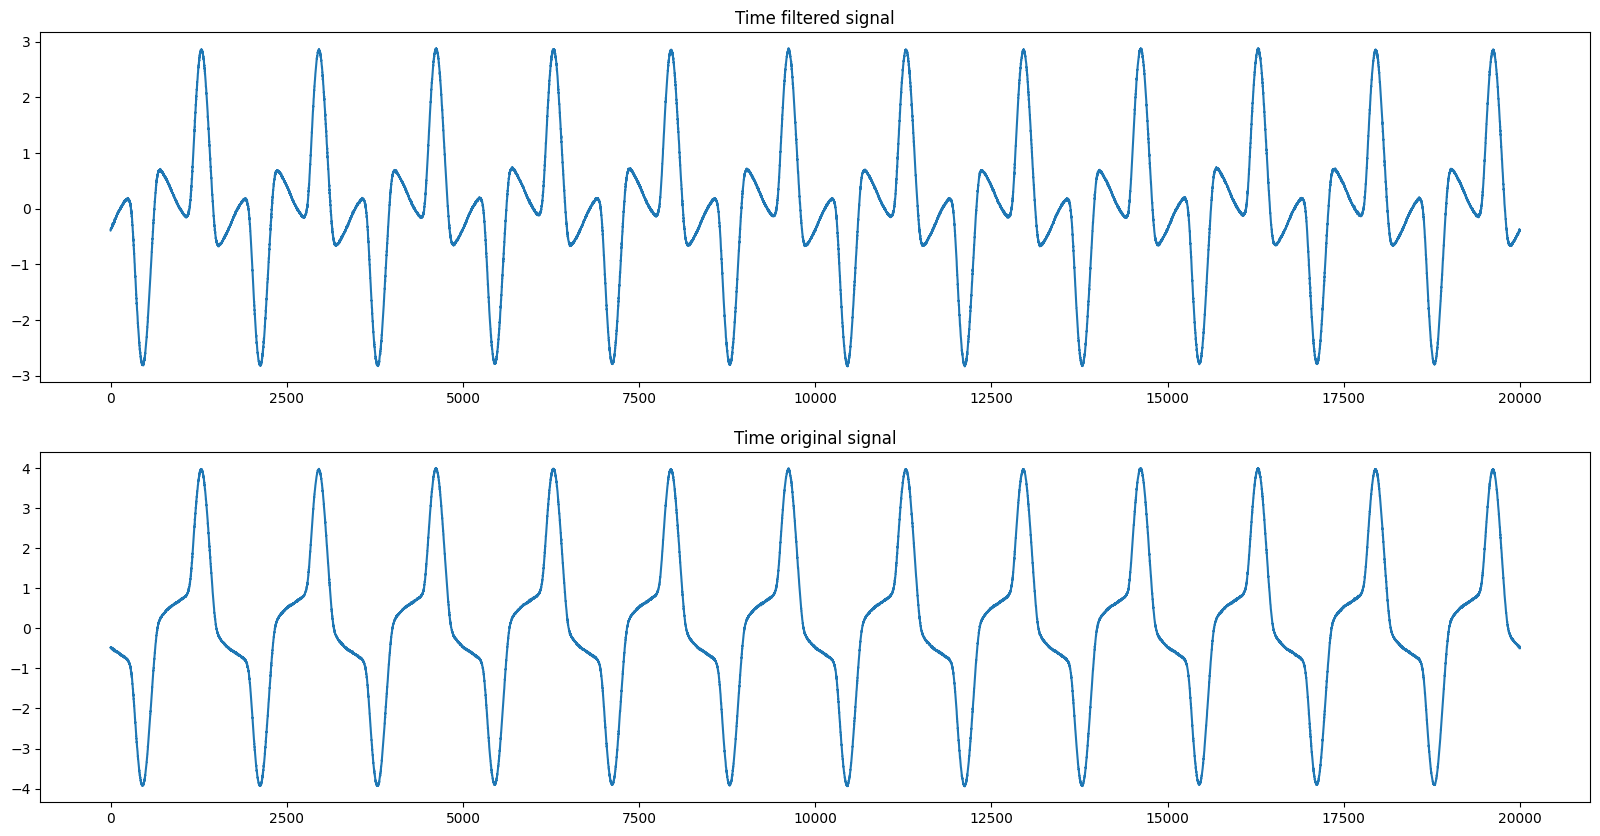

In [75]:
plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.plot(np.fft.ifft(df['fft_cut'][20]))
plt.title('Time filtered signal')
plt.subplot(3,1,2)
plt.plot(np.fft.ifft(df['fft'][20]))
plt.title('Time original signal')
plt.plot()
plt.show()

## Create database for training

In [184]:
np.random.seed(42)
N = 30

list_train_signal = []
labels = df['label'].unique()
feature_size = len(df['AFFTN'][0])
min_nb_labels = df['label'].value_counts().min()
dict_counter = {label:0 for label in labels}

for i in range(N):
    random_selection = np.random.randint(0,2, len(labels))
    mix = np.zeros(feature_size)
    present_labels = np.zeros(labels.shape)
    for i,label in enumerate(labels):
        if random_selection[i] == 1:
            mix += df['AFFTN'][df['label']=='Heater'].iloc[np.random.randint(0, min_nb_labels)]
            present_labels[i] = 1
            dict_counter[label] += 1


    list_train_signal.append({'AFFTN': mix, 'label': present_labels})

df_train = pd.DataFrame(list_train_signal)
df_train.head(20)
df_train.describe()

,AFFTN,label
count,30,30
unique,30,30
top,"[0.0021093919642131602, 2.727181255093289e-05,...","[0.0, 1.0, 0.0, 0.0, 0.0]"
freq,1,1


In [ ]:
# build svm
from sklearn.svm import SVC


## PCA

In [153]:
x = abs(np.array(df['fft'].to_list()))
#correlation matrix
x_cor = np.corrcoef(x)
x_cor.shape

(75, 75)

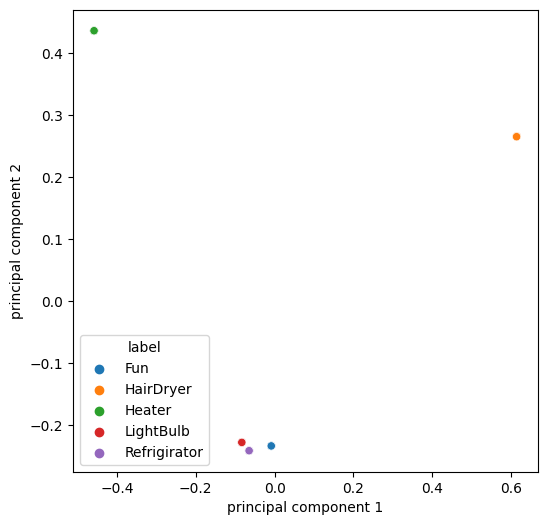

In [154]:
#apply PCA to fft column
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_cor)

#plot PCA
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

plt.figure(figsize=(6,6))
sns.scatterplot(x=principalDf['principal component 1'], y=principalDf['principal component 2'], hue=df['label'])  
#save figure
plt.savefig('pca.png')  
plt.show()

In [88]:
print(mat['tpd'][0].dtype)

[('Name', 'O'), ('DateTime', 'O'), ('RangeMin', 'O'), ('RangeMax', 'O'), ('SampleFrequency', 'O'), ('PreSampleCount', 'O'), ('StartValue', 'O'), ('Unit', 'O'), ('Data', 'O')]


In [80]:
print(mat['tpd']['Data'][0][0][0])

[-2.0068629 -2.0049021 -2.0215688 ... -1.9588237 -2.0078433 -1.9941177]
